In [120]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


from datasets import load_dataset

dataset = load_dataset("cifar10")

# Organizando os Dadoas

In [121]:
X_train_png  = dataset['train']['img']
y_train      = dataset['train']['label']

X_test_png  = dataset['test']['img']
y_test      = dataset['test']['label']



In [ ]:
""" X_train = []
X_test  = []
transf = transforms.ToTensor()


for x in X_train_png:
    prov = transf(x)
    X_train.append(prov)
    


    
for x in X_test_png:
    prov = transf(x)
    X_test.append(prov) """




# Dataset, DataLoader

In [133]:

class CIFAR10(Dataset):
    
    def __init__(self,X,y, transform=transforms.ToTensor()):
        
        self.transform = transform
        self.X = X
        self.y = y
          
    def __getitem__(self,idx):
        
        img_tensor = self.transform(self.X[idx])
        return img_tensor,self.y[idx]
    
    def __len__(self):
        return len(self.y)
    
    
    
# 

In [144]:
train_dl = DataLoader(CIFAR10(X_train_png,y_train),  batch_size = len(X_train_png) )
test_dl  = DataLoader(CIFAR10(X_test_png, y_test),  batch_size = len(X_test_png) )
                          

# Criando o Modelo

In [140]:
class MLP_Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        
        self.F1 = nn.Flatten()
        self.L1  = nn.Linear(3*32*32,64)
        self.L2  = nn.Linear(64, 32)
        self.L3  = nn.Linear(32,10)
        self.A   = nn.ReLU()
        
        
    def forward(self,x):
        
        x = self.F1(x)
        x = self.L1(x) 
        x = self.A(x)
        x = self.L2(x) 
        x = self.A(x)
        x = self.L3(x)
        x = self.A(x)
        
        return x
        

# Training

In [136]:

def training( N_Epochs, model, loss_fn, opt  ):
    
    loss_list = []
    
    for epoch in tqdm(range(N_Epochs+1)):
        for xb, yb in train_dl:
            
            
            
            y_pred = model(xb.float())
            loss   = loss_fn(y_pred, yb.long())
        
            
            opt.zero_grad()
            loss.backward()
            opt.step()
        
            loss_list.append(loss.item())
    
    L1_weights = MLP_Model().L1.weight.detach()
    L2_weights = MLP_Model().L2.weight.detach()
    L3_weights = MLP_Model().L3.weight.detach()
    
    
       
    
    plt.figure(figsize = (14,6))
    plt.title("cost decay")
    plt.plot(loss_list)
    plt.xlabel("epoch")
    plt.ylabel("cost")
    
    return L1_weights, L2_weights, L3_weights

  0%|          | 0/1501 [00:00<?, ?it/s]

100%|██████████| 1501/1501 [2:12:01<00:00,  5.28s/it] 


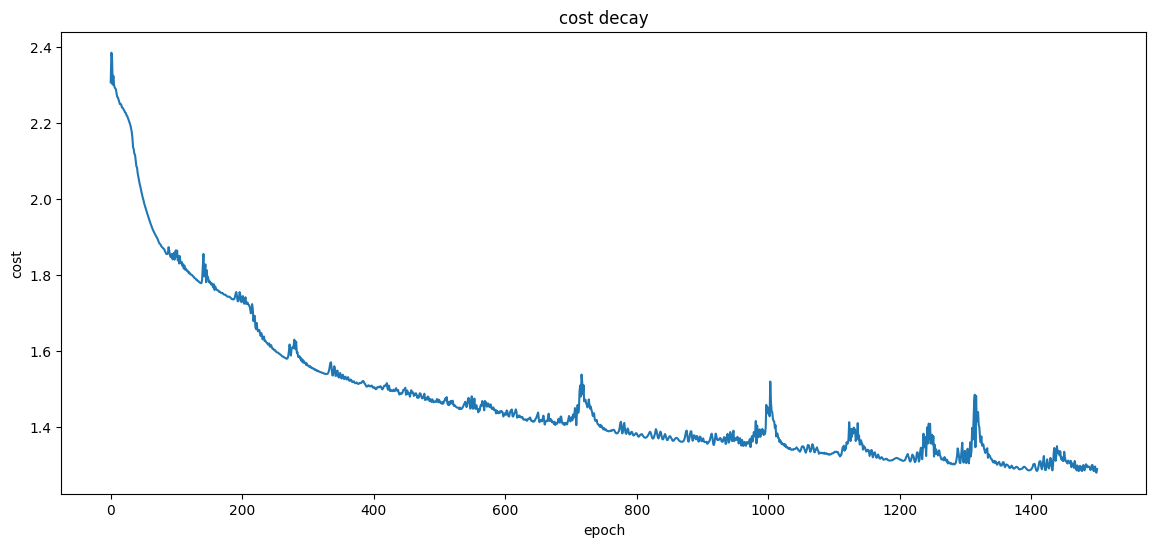

In [146]:
model = MLP_Model()

epochs = 1500

opt        = torch.optim.Adam( model.parameters(), lr=0.003 )

loss_fn    = nn.CrossEntropyLoss( )   

x1,x2,x3 = training( epochs, model , loss_fn, opt )

# Evaluation

In [147]:
from sklearn.metrics import classification_report
with torch.no_grad():
    
    model.eval()
    
    y_pred = []
    y_true = []

    for xb, yb in test_dl:
        y_predb = model(xb.float())
        y_pred.append(y_predb)
        y_true.append(yb)
        
    y_pred = torch.cat(y_pred)
    y_true = torch.cat(y_true)
  
    yf     = torch.argmax(y_pred, dim=1)

    print(classification_report(y_true, yf))        
    

              precision    recall  f1-score   support

           0       0.53      0.60      0.56      1000
           1       0.54      0.66      0.59      1000
           2       0.38      0.33      0.35      1000
           3       0.32      0.27      0.29      1000
           4       0.39      0.47      0.43      1000
           5       0.42      0.35      0.38      1000
           6       0.54      0.47      0.50      1000
           7       0.51      0.54      0.53      1000
           8       0.63      0.63      0.63      1000
           9       0.53      0.52      0.52      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.48     10000
weighted avg       0.48      0.48      0.48     10000

